<a href="https://colab.research.google.com/github/RoyZhaoGA/DroughtForecastAI/blob/main/Normalized_ORG_RUN_Regression_Spatial_temporal_graph_neural_networkV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=4432a39fdf90ae06ea68fe15390c9e5fcc1ef969489376ca805b6e22f8700bde
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Gen RAM Free: 87.7 GB  |     Proc size: 98.8 MB
GPU RAM Free: 40511MB | Used: 2MB | Util   0% | Total     40960MB


In [ ]:
!pip install lightning torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 55.4 MB/s eta 0:00:00


In [ ]:
!pip install torch --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
# Standard libraries
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import lightning as L

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from lightning.pytorch.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = min(1, torch.cuda.device_count())
#BATCH_SIZE = 256 if AVAIL_GPUS else 64
BATCH_SIZE = 1 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/DroughtCastAI/Dataset/GNNs"

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Import Graph

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
# spatial-temporal edges
Graph = pickle.load(open('/content/drive/MyDrive/DroughtCastAI/Dataset/Spatial_temporal_grpah_version_2_normalized_1month_selectedV7.pickle', 'rb'))

In [ ]:
Graph.nodes[36986]

{'row_index': 36986,
 'Month': 202211,
 'Lat': -33.238,
 'Lon': 18.865,
 'Lat_nom': 0.0,
 'Lon_nom': 0.5263211858448558,
 'temperature_2m': 0.4952498070987658,
 'temperature_2m_min': 0.5546942683872143,
 'temperature_2m_max': 0.6508211317768104,
 'dewpoint_temperature_2m': 0.604377704250445,
 'total_precipitation_sum': 0.0144451848511847,
 'total_precipitation_min': 0.0,
 'total_precipitation_max': 0.0178303713389214,
 'u_component_of_wind_10m': 0.5135674951104923,
 'v_component_of_wind_10m': 0.4987945801799406,
 'surface_net_solar_radiation_sum': 0.7802372071127209,
 'total_evaporation_sum': 0.8615671690632722,
 'soil_moisture_am': 0.1431131537144707,
 'soil_moisture_pm': 0.1428330811346103,
 'NDVI': 0.3818963898195212,
 'EVI': 0.291882789894304,
 'next_month_tempreature': 0.4275101180905905,
 'next_month_precipitation': 0.0111730676234768,
 'year': 0.875,
 'month2': 0.9090909090909092,
 'spei01': 0.4039815,
 'next_month_soil_moisture_am': 0.210090837587329,
 'next_month_spei01': 0.68

In [ ]:
len(Graph.nodes)

83580

In [ ]:
len(Graph.nodes[36986])

28

**Convert Graph into pytorch geometric dataset**

In [ ]:
#EDGE INDEX FOR FULL DATASET
# Extract edge list
edge_list = list(Graph.edges())




# Convert edge list to a 2D tensor
edge_index = torch.tensor(edge_list, dtype=torch.long)
edge_index = edge_index.t().contiguous()

# Ensure the tensor shape is [2, num_edges]

edge_index = edge_index.view(2, -1)



spei01_features = [Graph.nodes[node]['next_month_spei01'] for node in Graph.nodes()]



# Convert to a tensor
y = torch.tensor(spei01_features, dtype=torch.float)

feature_names = [ 'Lat_nom', 'Lon_nom', 'temperature_2m', 'temperature_2m_min',
                 'temperature_2m_max', 'dewpoint_temperature_2m', 'total_precipitation_sum',
                 'total_precipitation_min', 'total_precipitation_max', 'u_component_of_wind_10m',
                 'v_component_of_wind_10m', 'surface_net_solar_radiation_sum', 'total_evaporation_sum',
                 'soil_moisture_am', 'soil_moisture_pm', 'NDVI', 'EVI', 'next_month_tempreature',
                 'next_month_precipitation', 'year', 'month2', "spei01"]



# Extract the features for each node
node_features = []
for node in Graph.nodes():
    node_feature_values = [Graph.nodes[node].get(feature) for feature in feature_names]  # Defaulting missing values to 0
    node_features.append(node_feature_values)

# Convert to a PyTorch tensor
x = torch.tensor(node_features, dtype=torch.float)



train_months = [201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512,
201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608,
201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704,
201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712,
201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808,
201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904,
201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912,
202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008,
202009, 202010, 202011, 202012, 202101, 202102]
val_months = [202103, 202104, 202105, 202106, 202107, 202108, 202109,
202110, 202111, 202112, 202201, 202202, 202203, 202204, 202205]
test_months = [202206, 202207, 202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308]

train_mask_list = []

for node in Graph.nodes():
    is_in_train_months = Graph.nodes[node]['Month'] in train_months
    train_mask_list.append(is_in_train_months)

train_mask = torch.tensor(train_mask_list, dtype=torch.bool)

val_mask_list = []

for node in Graph.nodes():
    is_in_val_months = Graph.nodes[node]['Month'] in val_months
    val_mask_list.append(is_in_val_months)

val_mask = torch.tensor(val_mask_list, dtype=torch.bool)

test_mask_list = []

for node in Graph.nodes():
    is_in_test_months = Graph.nodes[node]['Month'] in test_months
    test_mask_list.append(is_in_test_months)

test_mask = torch.tensor(test_mask_list, dtype=torch.bool)

graph_data = torch_geometric.data.Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

In [ ]:
graph_data

Data(x=[83580, 22], edge_index=[2, 272260], y=[83580], train_mask=[83580], val_mask=[83580], test_mask=[83580])

In [ ]:
graph_data.x, graph_data.y

(tensor([[0.0000, 0.5263, 0.3982,  ..., 0.0000, 0.3636, 0.4354],
         [0.0000, 0.5526, 0.3498,  ..., 0.0000, 0.3636, 0.4940],
         [0.0000, 0.5789, 0.3752,  ..., 0.0000, 0.3636, 0.4604],
         ...,
         [1.0000, 0.3421, 0.6530,  ..., 1.0000, 0.6364, 0.2343],
         [1.0000, 0.3684, 0.6682,  ..., 1.0000, 0.6364, 0.3504],
         [1.0000, 0.3947, 0.6828,  ..., 1.0000, 0.6364, 0.3945]]),
 tensor([0.5642, 0.7461, 0.6896,  ..., 0.3055, 0.2828, 0.2375]))

In [ ]:
lossFun = nn.MSELoss()
selected_elements = graph_data.x[0:83580, 1]
print("selected_element",selected_elements)
print("y",graph_data.y)
loss = lossFun(selected_elements, graph_data.y)
print("loss",loss)

selected_element tensor([0.5263, 0.5526, 0.5789,  ..., 0.3421, 0.3684, 0.3947])
y tensor([0.5642, 0.7461, 0.6896,  ..., 0.3055, 0.2828, 0.2375])
loss tensor(0.0783)


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class GraphDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.num_node_features = data.x.size(1)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return graph_data

In [ ]:
graph_dataset = GraphDataset(graph_data)

In [ ]:
graph_dataset.data

Data(x=[83580, 22], edge_index=[2, 272260], y=[83580], train_mask=[83580], val_mask=[83580], test_mask=[83580])

In [ ]:
graph_dataset.__getitem__(0)

Data(x=[83580, 22], edge_index=[2, 272260], y=[83580], train_mask=[83580], val_mask=[83580], test_mask=[83580])

In [ ]:
graph_dataset.num_node_features

22

## Graph Neural Network

In [ ]:
gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

In [ ]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=1,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """GNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]


        print("Model Initialized")

        print("self:")
        print(self)

        print("c_in:")
        print(c_in)

        layers = []
        in_channels, out_channels = c_in, c_hidden


        #print(layers)

        for l_idx in range(num_layers - 1):
           # print("!!!layer", l_idx, in_channels, out_channels);
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels,v2=True, num_layers=2, **kwargs),
                nn.Tanh(),
                #nn.ReLU(inplace=True),
                #nn.Sigmoid(),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden


        #Output Layer:
        in_channels = c_hidden
       # layers += [nn.Tanh()]

        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        print("layers:")
        print(layers)
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """Forward.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        i=0
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
          # print("layer", i);
            i+=1
          #  print(layer)
            if isinstance(layer, geom_nn.MessagePassing):

                x = layer(x, edge_index)
            else:
                x = layer(x)
          #  print("----x:")
          #  print(x)
          #  print(x.size())
        return x

In [ ]:
global GModel

In [ ]:
loss_list = []

class NodeLevelRegressionGNN(L.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        # Initialize the model

        self.model = GNNModel(**model_kwargs)  # Ensure GNNModel outputs continuous values

        # Use Mean Squared Error Loss for regression
        self.loss_module = nn.MSELoss()
        #self.loss_module = nn.L1Loss(reduction='mean')

    def forward(self, data, mode="train"):

        x, edge_index = data.x, data.edge_index


        x = self.model(x, edge_index)

        global x_tensor
        x_tensor = x
        global y_tensor
        y_tensor = data.y


        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            raise ValueError(f"Unknown forward mode: {mode}")
        xMask=x[mask].squeeze()
        #yMask=data.y[mask].squeeze
        loss = self.loss_module(xMask, data.y[mask])

        print("Loss: ")
        print(loss)
        return loss

    def configure_optimizers(self):
        # Optimizer can be adjusted as needed
        #optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        optimizer = optim.Adam(self.parameters(),lr=0.01, weight_decay=5e-4)

        return optimizer

    def training_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="train")
        loss_list.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="val")
        self.log("val_loss", loss)
        print("#####################val_loss",loss)

    def test_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="test")
        self.log("test_loss", loss)

In [ ]:
def train_node_regressor(model_name, dataset, **model_kwargs):
    L.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevelRegression" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="train_loss")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=100,
        gradient_clip_val=20,

        enable_progress_bar=True
    )

    pretrained_filename = "bruh"
    os.path.join(CHECKPOINT_PATH, "NodeLevelRegression%s.ckpt" % model_name)
   # if os.path.isfile(pretrained_filename):
   #     print("Found pretrained model, loading...")
   #     model = NodeLevelRegressionGNN.load_from_checkpoint(pretrained_filename)
   # else:
    L.seed_everything()
    # Ensure the model's output layer and loss are suitable for regression
    model = NodeLevelRegressionGNN(
         model_name=model_name, c_in=dataset.num_node_features, c_out=1, **model_kwargs
    )
    trainer.fit(model, node_data_loader, node_data_loader)
    print("checkpoint_callback model path",trainer.checkpoint_callback.best_model_path)
    model = NodeLevelRegressionGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test the best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=True)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    train_loss = model.forward(batch, mode="train")
    val_loss = model.forward(batch, mode="val")
    result = {"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_result[0]["test_loss"]}
    return model, result

In [ ]:
# Small function for printing the test scores
def print_results(result_dict):
    if "train_loss" in result_dict:
        print("Train loss: " + str(result_dict["train_loss"]))
    if "val_loss" in result_dict:
        print("Val loss: " + str(result_dict["val_loss"]))
    print("Test loss: " + str(result_dict["test_loss"]))

In [ ]:

loss_list = []

node_gnn_model, node_gnn_result = train_node_regressor(
    model_name="GNN", layer_name="GAT", dataset=graph_dataset, c_hidden=16, num_layers=2, dp_rate=0.3
)

print_results(node_gnn_result)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type     | Params
-----------------------------------------
0 | model       | GNNModel | 419   
1 | loss_module | MSELoss  | 0     
-----------------------------------------
419       Trainable para

Model Initialized
self:
GNNModel()
c_in:
22
layers:
[GATConv(22, 16, heads=1), Tanh(), Dropout(p=0.3, inplace=False), GATConv(16, 1, heads=1)]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.1290, device='cuda:0')
#####################val_loss tensor(0.1290, device='cuda:0')


Training: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.2851, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0909, device='cuda:0')
#####################val_loss tensor(0.0909, device='cuda:0')
Loss: 
tensor(0.1260, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.2658, device='cuda:0')
#####################val_loss tensor(0.2658, device='cuda:0')
Loss: 
tensor(0.2315, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.1964, device='cuda:0')
#####################val_loss tensor(0.1964, device='cuda:0')
Loss: 
tensor(0.1873, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0730, device='cuda:0')
#####################val_loss tensor(0.0730, device='cuda:0')
Loss: 
tensor(0.1148, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0277, device='cuda:0')
#####################val_loss tensor(0.0277, device='cuda:0')
Loss: 
tensor(0.1179, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0419, device='cuda:0')
#####################val_loss tensor(0.0419, device='cuda:0')
Loss: 
tensor(0.1561, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0443, device='cuda:0')
#####################val_loss tensor(0.0443, device='cuda:0')
Loss: 
tensor(0.1604, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0287, device='cuda:0')
#####################val_loss tensor(0.0287, device='cuda:0')
Loss: 
tensor(0.1237, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0302, device='cuda:0')
#####################val_loss tensor(0.0302, device='cuda:0')
Loss: 
tensor(0.0968, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0633, device='cuda:0')
#####################val_loss tensor(0.0633, device='cuda:0')
Loss: 
tensor(0.0987, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.1021, device='cuda:0')
#####################val_loss tensor(0.1021, device='cuda:0')
Loss: 
tensor(0.1171, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.1114, device='cuda:0')
#####################val_loss tensor(0.1114, device='cuda:0')
Loss: 
tensor(0.1212, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0863, device='cuda:0')
#####################val_loss tensor(0.0863, device='cuda:0')
Loss: 
tensor(0.1059, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0501, device='cuda:0')
#####################val_loss tensor(0.0501, device='cuda:0')
Loss: 
tensor(0.0855, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0270, device='cuda:0')
#####################val_loss tensor(0.0270, device='cuda:0')
Loss: 
tensor(0.0822, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0222, device='cuda:0')
#####################val_loss tensor(0.0222, device='cuda:0')
Loss: 
tensor(0.0884, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0241, device='cuda:0')
#####################val_loss tensor(0.0241, device='cuda:0')
Loss: 
tensor(0.0937, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0869, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0214, device='cuda:0')
#####################val_loss tensor(0.0214, device='cuda:0')
Loss: 
tensor(0.0759, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0280, device='cuda:0')
#####################val_loss tensor(0.0280, device='cuda:0')
Loss: 
tensor(0.0684, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0428, device='cuda:0')
#####################val_loss tensor(0.0428, device='cuda:0')
Loss: 
tensor(0.0691, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0553, device='cuda:0')
#####################val_loss tensor(0.0553, device='cuda:0')
Loss: 
tensor(0.0729, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0551, device='cuda:0')
#####################val_loss tensor(0.0551, device='cuda:0')
Loss: 
tensor(0.0711, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0431, device='cuda:0')
#####################val_loss tensor(0.0431, device='cuda:0')
Loss: 
tensor(0.0623, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0290, device='cuda:0')
#####################val_loss tensor(0.0290, device='cuda:0')
Loss: 
tensor(0.0566, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0211, device='cuda:0')
#####################val_loss tensor(0.0211, device='cuda:0')
Loss: 
tensor(0.0562, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0197, device='cuda:0')
#####################val_loss tensor(0.0197, device='cuda:0')
Loss: 
tensor(0.0576, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0198, device='cuda:0')
#####################val_loss tensor(0.0198, device='cuda:0')
Loss: 
tensor(0.0564, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0194, device='cuda:0')
#####################val_loss tensor(0.0194, device='cuda:0')
Loss: 
tensor(0.0527, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0209, device='cuda:0')
#####################val_loss tensor(0.0209, device='cuda:0')
Loss: 
tensor(0.0467, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0265, device='cuda:0')
#####################val_loss tensor(0.0265, device='cuda:0')
Loss: 
tensor(0.0453, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0326, device='cuda:0')
#####################val_loss tensor(0.0326, device='cuda:0')
Loss: 
tensor(0.0458, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0339, device='cuda:0')
#####################val_loss tensor(0.0339, device='cuda:0')
Loss: 
tensor(0.0457, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0292, device='cuda:0')
#####################val_loss tensor(0.0292, device='cuda:0')
Loss: 
tensor(0.0417, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0229, device='cuda:0')
#####################val_loss tensor(0.0229, device='cuda:0')
Loss: 
tensor(0.0383, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0193, device='cuda:0')
#####################val_loss tensor(0.0193, device='cuda:0')
Loss: 
tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0187, device='cuda:0')
#####################val_loss tensor(0.0187, device='cuda:0')
Loss: 
tensor(0.0381, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0187, device='cuda:0')
#####################val_loss tensor(0.0187, device='cuda:0')
Loss: 
tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0186, device='cuda:0')
#####################val_loss tensor(0.0186, device='cuda:0')
Loss: 
tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0197, device='cuda:0')
#####################val_loss tensor(0.0197, device='cuda:0')
Loss: 
tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0222, device='cuda:0')
#####################val_loss tensor(0.0222, device='cuda:0')
Loss: 
tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0239, device='cuda:0')
#####################val_loss tensor(0.0239, device='cuda:0')
Loss: 
tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0228, device='cuda:0')
#####################val_loss tensor(0.0228, device='cuda:0')
Loss: 
tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0203, device='cuda:0')
#####################val_loss tensor(0.0203, device='cuda:0')
Loss: 
tensor(0.0292, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0186, device='cuda:0')
#####################val_loss tensor(0.0186, device='cuda:0')
Loss: 
tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0184, device='cuda:0')
#####################val_loss tensor(0.0184, device='cuda:0')
Loss: 
tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0185, device='cuda:0')
#####################val_loss tensor(0.0185, device='cuda:0')
Loss: 
tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0184, device='cuda:0')
#####################val_loss tensor(0.0184, device='cuda:0')
Loss: 
tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0186, device='cuda:0')
#####################val_loss tensor(0.0186, device='cuda:0')
Loss: 
tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0194, device='cuda:0')
#####################val_loss tensor(0.0194, device='cuda:0')
Loss: 
tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0199, device='cuda:0')
#####################val_loss tensor(0.0199, device='cuda:0')
Loss: 
tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0195, device='cuda:0')
#####################val_loss tensor(0.0195, device='cuda:0')
Loss: 
tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0186, device='cuda:0')
#####################val_loss tensor(0.0186, device='cuda:0')
Loss: 
tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0184, device='cuda:0')
#####################val_loss tensor(0.0184, device='cuda:0')
Loss: 
tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0186, device='cuda:0')
#####################val_loss tensor(0.0186, device='cuda:0')
Loss: 
tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0186, device='cuda:0')
#####################val_loss tensor(0.0186, device='cuda:0')
Loss: 
tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0184, device='cuda:0')
#####################val_loss tensor(0.0184, device='cuda:0')
Loss: 
tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0184, device='cuda:0')
#####################val_loss tensor(0.0184, device='cuda:0')
Loss: 
tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0186, device='cuda:0')
#####################val_loss tensor(0.0186, device='cuda:0')
Loss: 
tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0186, device='cuda:0')
#####################val_loss tensor(0.0186, device='cuda:0')
Loss: 
tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0184, device='cuda:0')
#####################val_loss tensor(0.0184, device='cuda:0')
Loss: 
tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0183, device='cuda:0')
#####################val_loss tensor(0.0183, device='cuda:0')
Loss: 
tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0184, device='cuda:0')
#####################val_loss tensor(0.0184, device='cuda:0')
Loss: 
tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0185, device='cuda:0')
#####################val_loss tensor(0.0185, device='cuda:0')
Loss: 
tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0183, device='cuda:0')
#####################val_loss tensor(0.0183, device='cuda:0')
Loss: 
tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0182, device='cuda:0')
#####################val_loss tensor(0.0182, device='cuda:0')
Loss: 
tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0182, device='cuda:0')
#####################val_loss tensor(0.0182, device='cuda:0')
Loss: 
tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0182, device='cuda:0')
#####################val_loss tensor(0.0182, device='cuda:0')
Loss: 
tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0181, device='cuda:0')
#####################val_loss tensor(0.0181, device='cuda:0')
Loss: 
tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0181, device='cuda:0')
#####################val_loss tensor(0.0181, device='cuda:0')
Loss: 
tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0182, device='cuda:0')
#####################val_loss tensor(0.0182, device='cuda:0')
Loss: 
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0182, device='cuda:0')
#####################val_loss tensor(0.0182, device='cuda:0')
Loss: 
tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0181, device='cuda:0')
#####################val_loss tensor(0.0181, device='cuda:0')
Loss: 
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0180, device='cuda:0')
#####################val_loss tensor(0.0180, device='cuda:0')
Loss: 
tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0180, device='cuda:0')
#####################val_loss tensor(0.0180, device='cuda:0')
Loss: 
tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0180, device='cuda:0')
#####################val_loss tensor(0.0180, device='cuda:0')
Loss: 
tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0180, device='cuda:0')
#####################val_loss tensor(0.0180, device='cuda:0')
Loss: 
tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0180, device='cuda:0')
#####################val_loss tensor(0.0180, device='cuda:0')
Loss: 
tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0180, device='cuda:0')
#####################val_loss tensor(0.0180, device='cuda:0')
Loss: 
tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0180, device='cuda:0')
#####################val_loss tensor(0.0180, device='cuda:0')
Loss: 
tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0179, device='cuda:0')
#####################val_loss tensor(0.0179, device='cuda:0')
Loss: 
tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0178, device='cuda:0')
#####################val_loss tensor(0.0178, device='cuda:0')
Loss: 
tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0178, device='cuda:0')
#####################val_loss tensor(0.0178, device='cuda:0')
Loss: 
tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0178, device='cuda:0')
#####################val_loss tensor(0.0178, device='cuda:0')


INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


checkpoint_callback model path /content/drive/MyDrive/DroughtCastAI/Dataset/GNNs/NodeLevelRegressionGNN/lightning_logs/version_368/checkpoints/epoch=99-step=100.ckpt


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model Initialized
self:
GNNModel()
c_in:
22
layers:
[GATConv(22, 16, heads=1), Tanh(), Dropout(p=0.3, inplace=False), GATConv(16, 1, heads=1)]


Testing: |          | 0/? [00:00<?, ?it/s]

Loss: 
tensor(0.0217, device='cuda:0')


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.02172897383570671    │
└───────────────────────────┴───────────────────────────┘

Loss: 
tensor(0.0206, grad_fn=<MseLossBackward0>)
Loss: 
tensor(0.0230, grad_fn=<MseLossBackward0>)
Train loss: tensor(0.0206, grad_fn=<MseLossBackward0>)
Val loss: tensor(0.0230, grad_fn=<MseLossBackward0>)
Test loss: 0.02172897383570671


In [ ]:
#Predicted values
x_tensor

tensor([[0.4070],
        [0.6362],
        [0.5790],
        ...,
        [0.3019],
        [0.4092],
        [0.5487]], grad_fn=<AddBackward0>)

In [ ]:
torch.mean(x_tensor)

tensor(0.4314, grad_fn=<MeanBackward0>)

In [ ]:
torch.std(x_tensor)

tensor(0.0715, grad_fn=<StdBackward0>)

In [ ]:
torch.min(x_tensor)

tensor(-0.1401, grad_fn=<MinBackward1>)

In [ ]:
torch.max(x_tensor)

tensor(0.9072, grad_fn=<MaxBackward1>)

In [ ]:
x_tensor.size()

torch.Size([83580, 1])

In [ ]:
#Actual values
y_tensor

tensor([0.5642, 0.7461, 0.6896,  ..., 0.3055, 0.2828, 0.2375])

In [ ]:
torch.std(y_tensor)

tensor(0.1345)

In [ ]:
y_tensor.std()

tensor(0.1345)

In [ ]:
y_tensor.mean()

tensor(0.4353)

In [ ]:
#Calculate MSE between predicted and actual value
def mean_squared_error(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    return mse

In [ ]:
mean_squared_error(x_tensor, y_tensor)

tensor(0.0232, grad_fn=<MeanBackward0>)

In [ ]:
mse=None
torch.cuda.empty_cache()

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_loss_graph(loss_data):
    """
    Plots the training loss over epochs.

    :param loss_data: List of loss values (as PyTorch tensors).
    """
    # Convert tensor list to a list of Python floats

    # Epochs (assuming each loss value corresponds to an epoch)
    epochs = range(1, len(loss_data) + 1)

    # Creating the plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_data, marker='o', color='b', label='Training Loss')

    # Adding titles and labels
    plt.title('Epochs vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plot
    plt.show()


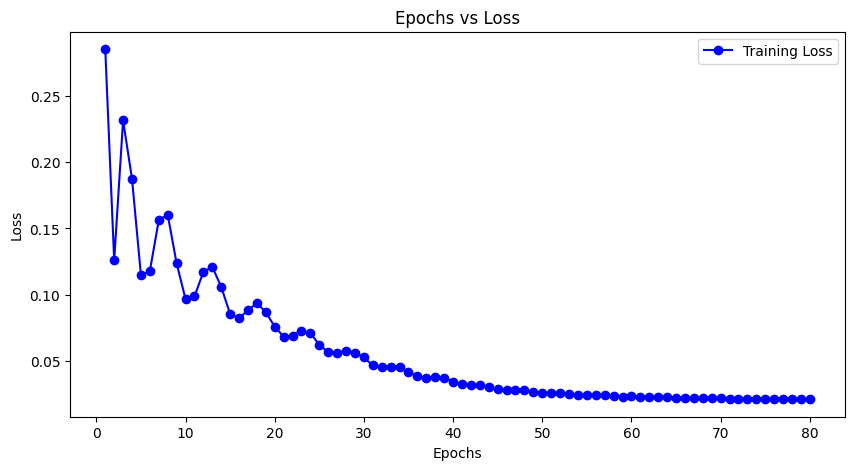

In [ ]:
plot_loss_graph(loss_list)

tensor([[0.4070],
        [0.6362],
        [0.5790],
        ...,
        [0.3019],
        [0.4092],
        [0.5487]], grad_fn=<AddBackward0>)
<built-in method max of Tensor object at 0x7db48fc430b0>
tensor([0.5642, 0.7461, 0.6896,  ..., 0.3055, 0.2828, 0.2375])


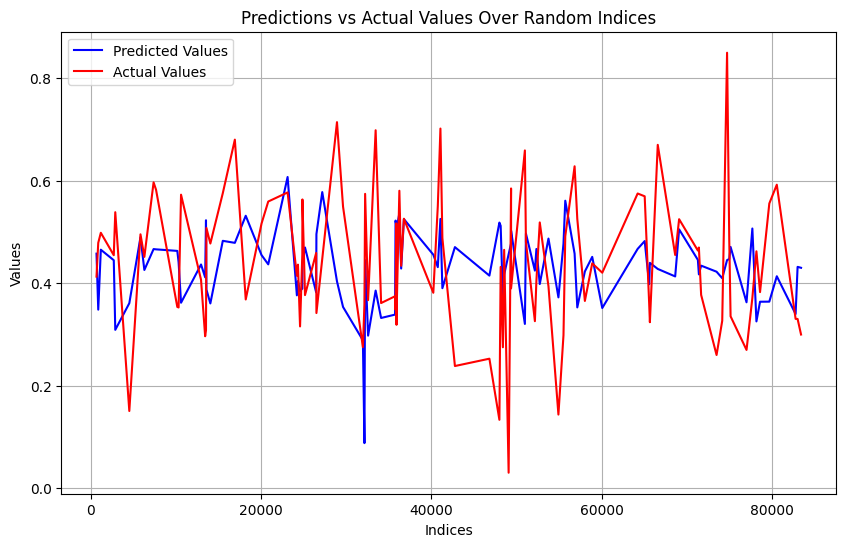

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print(x_tensor);
print(x_tensor.max)
print(y_tensor);
random_indices = np.random.choice(len(x_tensor), 100, replace=False)
random_indices_sorted = np.sort(random_indices)

# Select elements from tensor_x and tensor_y based on these indices
selected_tensor_x = x_tensor[random_indices].detach()
selected_tensor_y = y_tensor[random_indices].detach()

plt.figure(figsize=(10, 6))

# Plotting the lines
plt.plot(random_indices_sorted, selected_tensor_x.numpy(), label='Predicted Values', color='blue')
plt.plot(random_indices_sorted, selected_tensor_y.numpy(), label='Actual Values', color='red')

plt.title("Predictions vs Actual Values Over Random Indices")
plt.xlabel("Indices")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

**IGNORE THE CODE BELOW THIS**

10 hidden size, 2 hidden layers:
Train loss: tensor(1.7932, grad_fn=<MseLossBackward0>)
Val loss: tensor(1.7155, grad_fn=<MseLossBackward0>)
Test loss: 2.1073737144470215

10 hidden size, 3 hidden layers: Train loss: tensor(1.7858, grad_fn=<MseLossBackward0>)
Val loss: tensor(1.7060, grad_fn=<MseLossBackward0>)
Test loss: 2.1036555767059326

10 hidden size, 5 hidden layers: Train loss: tensor(1.7800, grad_fn=<MseLossBackward0>)
Val loss: tensor(1.7009, grad_fn=<MseLossBackward0>)
Test loss: 2.105391502380371

In [ ]:
loss_list

[0.30162572860717773,
 0.16265065968036652,
 0.2503145635128021,
 0.19576720893383026,
 0.12805649638175964,
 0.13516779243946075,
 0.16525214910507202,
 0.16180358827114105,
 0.12431052327156067,
 0.10329487174749374,
 0.10880603641271591,
 0.12442180514335632,
 0.12194493412971497,
 0.10486292839050293,
 0.08905848115682602,
 0.08758539706468582,
 0.09446561336517334,
 0.0957198366522789,
 0.08678881078958511,
 0.07515930384397507,
 0.07016570121049881,
 0.07240103930234909,
 0.07429666072130203,
 0.06982981413602829,
 0.061407167464494705,
 0.05737409368157387,
 0.05804957449436188,
 0.059038810431957245,
 0.056659113615751266,
 0.051392439752817154,
 0.04740414768457413,
 0.047871340066194534,
 0.04833768680691719,
 0.046006593853235245,
 0.04257666692137718,
 0.03995504975318909,
 0.040026839822530746,
 0.039320267736911774,
 0.0379481241106987,
 0.034962695091962814,
 0.03385176882147789,
 0.03388405591249466,
 0.03297184407711029,
 0.031084608286619186,
 0.02965674176812172,
 0.

In [ ]:
len(loss_list)

200

In [ ]:
import torch
print(torch.cuda.is_available())

True


Although the MLP can overfit on the training dataset because of the high-dimensional input features,
it does not perform too well on the test set.
Let's see if we can beat this score with our graph networks: